In [455]:
from pathlib import Path
import xarray as xr
from shared.training import split_data_on_participants, train_and_evaluate
from shared.normalization import *
from shared.models import SAT1Base
import tensorflow as tf
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
import matplotlib.pyplot as plt
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import numpy as np
from tf_keras_vis.activation_maximization.callbacks import Progress
from mne.viz import plot_topomap
from mne.io import read_info

### Activation Maximization

In [5]:
data_path = Path("data/sat1/split_stage_data.nc")

data = xr.load_dataset(data_path)

In [6]:
train_data, val_data, test_data = split_data_on_participants(data, 60, norm_0_to_1)

In [7]:
model = SAT1Base(len(data.channels), len(data.samples), len(data.labels))
model.compile(
    optimizer=tf.keras.optimizers.Nadam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

2023-10-03 11:47:12.142068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-03 11:47:12.168968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-03 11:47:12.169040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-03 11:47:12.170368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-03 11:47:12.170431: I tensorflow/compile

In [8]:
train_and_evaluate(
    model, train_data, val_data, test_data, epochs=20, logs_path=Path("logs/")
)

Epoch 1/20


2023-10-03 11:47:16.720456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-03 11:47:17.341826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-03 11:47:17.638469: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5646a00aa260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-03 11:47:17.638504: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-10-03 11:47:17.644582: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-03 11:47:17.753052: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

765/765 [==============================] - 15s 15ms/step - loss: 1.1656 - accuracy: 0.4839 - val_loss: 1.0541 - val_accuracy: 0.5819
Epoch 2/20
765/765 [==============================] - 12s 15ms/step - loss: 0.8871 - accuracy: 0.6443 - val_loss: 0.6828 - val_accuracy: 0.7301
Epoch 3/20
765/765 [==============================] - 12s 15ms/step - loss: 0.6953 - accuracy: 0.7319 - val_loss: 0.6281 - val_accuracy: 0.7602
Epoch 4/20
765/765 [==============================] - 12s 15ms/step - loss: 0.6133 - accuracy: 0.7648 - val_loss: 0.5633 - val_accuracy: 0.7854
Epoch 5/20
765/765 [==============================] - 12s 15ms/step - loss: 0.5666 - accuracy: 0.7839 - val_loss: 0.5532 - val_accuracy: 0.7846
Epoch 6/20
765/765 [==============================] - 12s 15ms/step - loss: 0.5417 - accuracy: 0.7934 - val_loss: 0.5326 - val_accuracy: 0.7963
Epoch 7/20
765/765 [==============================] - 12s 15ms/step - loss: 0.5084 - accuracy: 0.8076 - val_loss: 0.5449 - val_accuracy: 0.7933
Epo

(<keras.src.callbacks.History at 0x7f3423a79e50>, None)

In [413]:
# Label 1
labels_idx = list(np.arange(0, len(data.labels)))
score = CategoricalScore(labels_idx)
modifier = ReplaceToLinear()
positions = read_info(Path("data/sat1/preprocessed/processed_0001_epo.fif"))

In [450]:
visualizer = ActivationMaximization(model, modifier, clone=True)

In [432]:
visualizer = Gradcam(model, modifier, clone=True)

In [456]:
visualizer = Saliency(model, modifier, clone=True)

In [457]:
seed_input_big = tf.random.uniform((5, len(data.samples), len(data.channels), 1), 0, 1)
activations = visualizer(score, seed_input_big, smooth_samples=20, smooth_noise=0.20)

In [447]:
seed_input_big = tf.random.uniform((5, len(data.samples), len(data.channels), 1), 0, 1)
activations = visualizer(
    score, seed_input=seed_input_big, penultimate_layer=-10, training=False
)

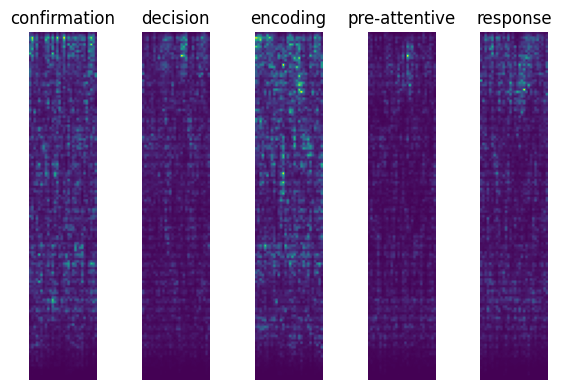

In [459]:
f, ax = plt.subplots(nrows=1, ncols=len(labels_idx), figsize=(6, 4))
for i, title in enumerate(data.labels):
    ax[i].set_title(title.item())
    ax[i].imshow(activations[i])
    ax[i].axis("off")
# ax.axis('off')
plt.tight_layout()
plt.show()

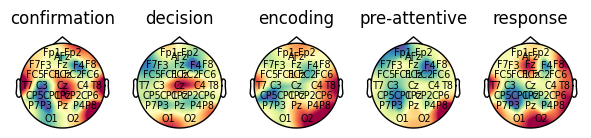

In [460]:
f, ax = plt.subplots(nrows=1, ncols=len(labels_idx), figsize=(6, 4))
timesteps = np.arange(0, len(data.samples), 10)
for label_idx in labels_idx:
    activations_new_mean = np.mean(np.squeeze(activations[label_idx]), axis=0)
    vmin = np.min(activations_new_mean)
    vmax = np.max(activations_new_mean)
    ax[label_idx].set_title(data.labels[label_idx].item())
    plot_topomap(
        activations_new_mean,
        positions,
        axes=ax[label_idx],
        show=False,
        cmap="Spectral_r",
        vlim=(vmin, vmax),
        sensors=False,
        contours=0,
        names=data.channels.to_numpy(),
    )
    # plt.title(data.labels[label_idx].item())
plt.tight_layout()
plt.show()

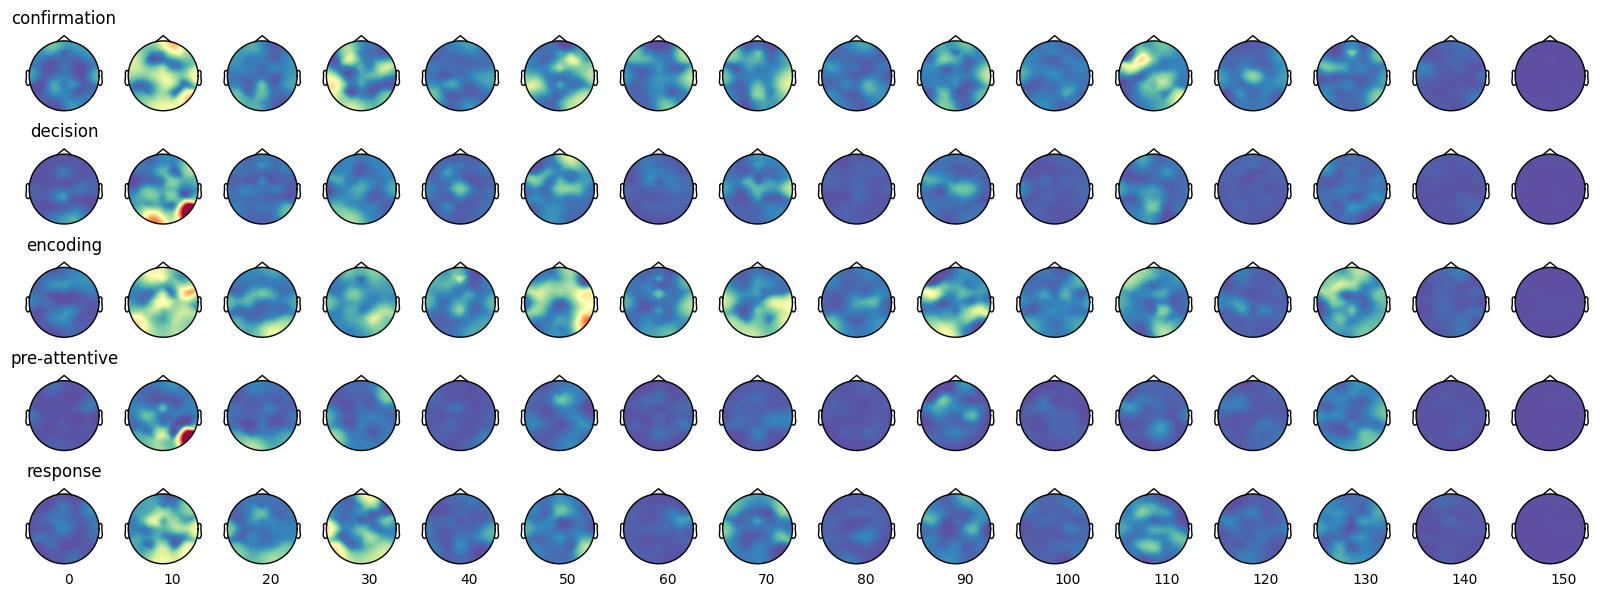

In [461]:
timesteps = np.arange(0, len(data.samples), 10)
f, axs = plt.subplots(
    nrows=len(labels_idx),
    ncols=len(timesteps),
    figsize=(len(timesteps), 6),
    sharex=True,
)
vmin = np.min(activations)
vmax = np.max(activations)
plt.setp(axs, xticks=timesteps)
for label_idx in labels_idx:
    axs[label_idx, 0].set_title(data.labels[label_idx].item())
    for i, timestep in enumerate(timesteps):
        # axs[i, label_idx].set_ylabels(str(timestep))

        activations_new = np.squeeze(activations[label_idx])
        # vmin = np.min(activations_new[timestep, :])
        # vmax = np.max(activations_new[timestep, :])
        plot_topomap(
            activations_new[timestep, :],
            positions,
            axes=axs[label_idx, i],
            show=False,
            cmap="Spectral_r",
            vlim=(vmin, vmax),
            sensors=False,
            contours=0,
            res=32,
        )
        if label_idx == labels_idx[-1]:
            axs[label_idx, i].text(0, -0.15, str(timestep))
plt.tight_layout()
plt.show()

In [453]:
seed_input_big = tf.random.uniform((5, len(data.samples), len(data.channels), 1), 0, 1)
activations = visualizer(
    score,
    seed_input=seed_input_big,
    callbacks=[Progress()],
    input_range=(0.0, 255.0),
    steps=200,
    training=True,
    # optimizer=tf.keras.optimizers.Adam(),
    # input_modifiers=[input_modifiers.Jitter(1)],
    input_modifiers=[],
)

200/200 [==============================] - 5s 24ms/step - Score: 504732.6875 - TotalVariation2D: 382.0099 - Norm: 52.4938


In [ ]:
activations = []
for label in labels_idx:
    seed_input = tf.random.uniform((len(data.samples), len(data.channels), 1), 0, 1)
    activation = visualizer(
        CategoricalScore(label),
        seed_input=seed_input,
        penultimate_layer=-6,
        training=True,
    )
    print(label, activation)
    activations.append(np.squeeze(activation))
activations = np.array(activations)